# Step Function project




The goal is to have a webapp where user enters any language and we detect the sentiment. We also want to store the input and sentiment to DynamoDB as well as send an email.

We'll host the app on EC2, it will be a simle node.js app, when a user passes input we'll call a API. 
Side thing: we also create a SNS subscription that we'll inform us to email when user enters something and create a DynamoDB table that will store the inputs, we just need to provide the primary key (which we can use Time as a string to keep things simple).

# Gateway
This API will be hosted by API Gateway, in the POST method, under integration request we need to call StepFunction, we'll have a mapping template that would point to it (we'll call it `FeedbackStateMachine`):
```json
{   
    "input": "{\"body\" : \"$input.path('$.input')\"}",
    "stateMachineArn": "arn:aws:states:us-east-1:<account_number>:stateMachine:FeedbackStateMachine"
}
```

## AWS Lambda

Now let's create a Lambda function that will do the "heavier lifting", namely calling AWS Comprehend to get the sentiment.

```python
import boto3
import json

def lambda_handler(event, context):
    step_functions = boto3.client('stepfunctions')
    comprehend = boto3.client('comprehend')
    
    input_text = event['Review']
    response = comprehend.detect_sentiment(Text=input_text, LanguageCode='en')
    sentiment_result = response['Sentiment']
    
    task_token = event['MyTaskToken']
    
    # Send the result in a format that matches the expected path
    result_payload = {"Payload": {"Sentiment": sentiment_result}}
    print(result_payload)
        
    step_functions.send_task_success(
        taskToken=task_token,
        output=json.dumps(result_payload)
    )
```

## Step Function

And we are all set to make FeedbackStateMachine StepFunction. This is not as straightforward as this is written in a completely new language, UI is there to help but still, lot's of tricks.
the ultimate code looks like this:
```json
{
  "Comment": "A description of my state machine",
  "StartAt": "DetectDominantLanguage",
  "States": {
    "DetectDominantLanguage": {
      "Type": "Task",
      "Parameters": {
        "Text.$": "$.body"
      },
      "Resource": "arn:aws:states:::aws-sdk:comprehend:detectDominantLanguage",
      "Next": "Choice",
      "ResultPath": "$.New"
    },
    "Choice": {
      "Type": "Choice",
      "Choices": [
        {
          "Variable": "$.New.Languages[0].LanguageCode",
          "StringMatches": "en",
          "Next": "Pass"
        }
      ],
      "Default": "TranslateText"
    },
    "Pass": {
      "Type": "Pass",
      "Next": "Lambda Invoke"
    },
    "Lambda Invoke": {
      "Type": "Task",
      "Resource": "arn:aws:states:::lambda:invoke.waitForTaskToken",
      "Parameters": {
        "FunctionName": "arn:aws:lambda:us-east-1:106785241709:function:SentimentAnalysisFunction:$LATEST",
        "Payload": {
          "Review.$": "$.body",
          "MyTaskToken.$": "$$.Task.Token"
        }
      },
      "Retry": [
        {
          "ErrorEquals": [
            "Lambda.ServiceException",
            "Lambda.AWSLambdaException",
            "Lambda.SdkClientException",
            "Lambda.TooManyRequestsException"
          ],
          "IntervalSeconds": 1,
          "MaxAttempts": 3,
          "BackoffRate": 2
        }
      ],
      "ResultPath": "$.Result",
      "Next": "Parallel"
    },
    "Parallel": {
      "Type": "Parallel",
      "End": true,
      "Branches": [
        {
          "StartAt": "SNS Publish",
          "States": {
            "SNS Publish": {
              "Type": "Task",
              "Resource": "arn:aws:states:::sns:publish",
              "Parameters": {
                "TopicArn": "arn:aws:sns:us-east-1:106785241709:EmailNotificationTopic",
                "Message": {
                  "Review.$": "$.body",
                  "Sentiment.$": "$.Result.Payload.Sentiment"
                }
              },
              "End": true
            }
          }
        },
        {
          "StartAt": "DynamoDB PutItem",
          "States": {
            "DynamoDB PutItem": {
              "Type": "Task",
              "Resource": "arn:aws:states:::dynamodb:putItem",
              "Parameters": {
                "TableName": "ReviewsTable",
                "Item": {
                  "Time": {
                    "S.$": "$$.State.EnteredTime"
                  },
                  "Review": {
                    "S.$": "$.body"
                  },
                  "Sentiment": {
                    "S.$": "$.Result.Payload.Sentiment"
                  }
                }
              },
              "End": true
            }
          }
        }
      ]
    },
    "TranslateText": {
      "Type": "Task",
      "Parameters": {
        "SourceLanguageCode.$": "$.New.Languages[0].LanguageCode",
        "TargetLanguageCode": "en",
        "Text.$": "$.body"
      },
      "Resource": "arn:aws:states:::aws-sdk:translate:translateText",
      "ResultSelector": {
        "body.$": "$.TranslatedText"
      },
      "Next": "Lambda Invoke"
    }
  }
}
```



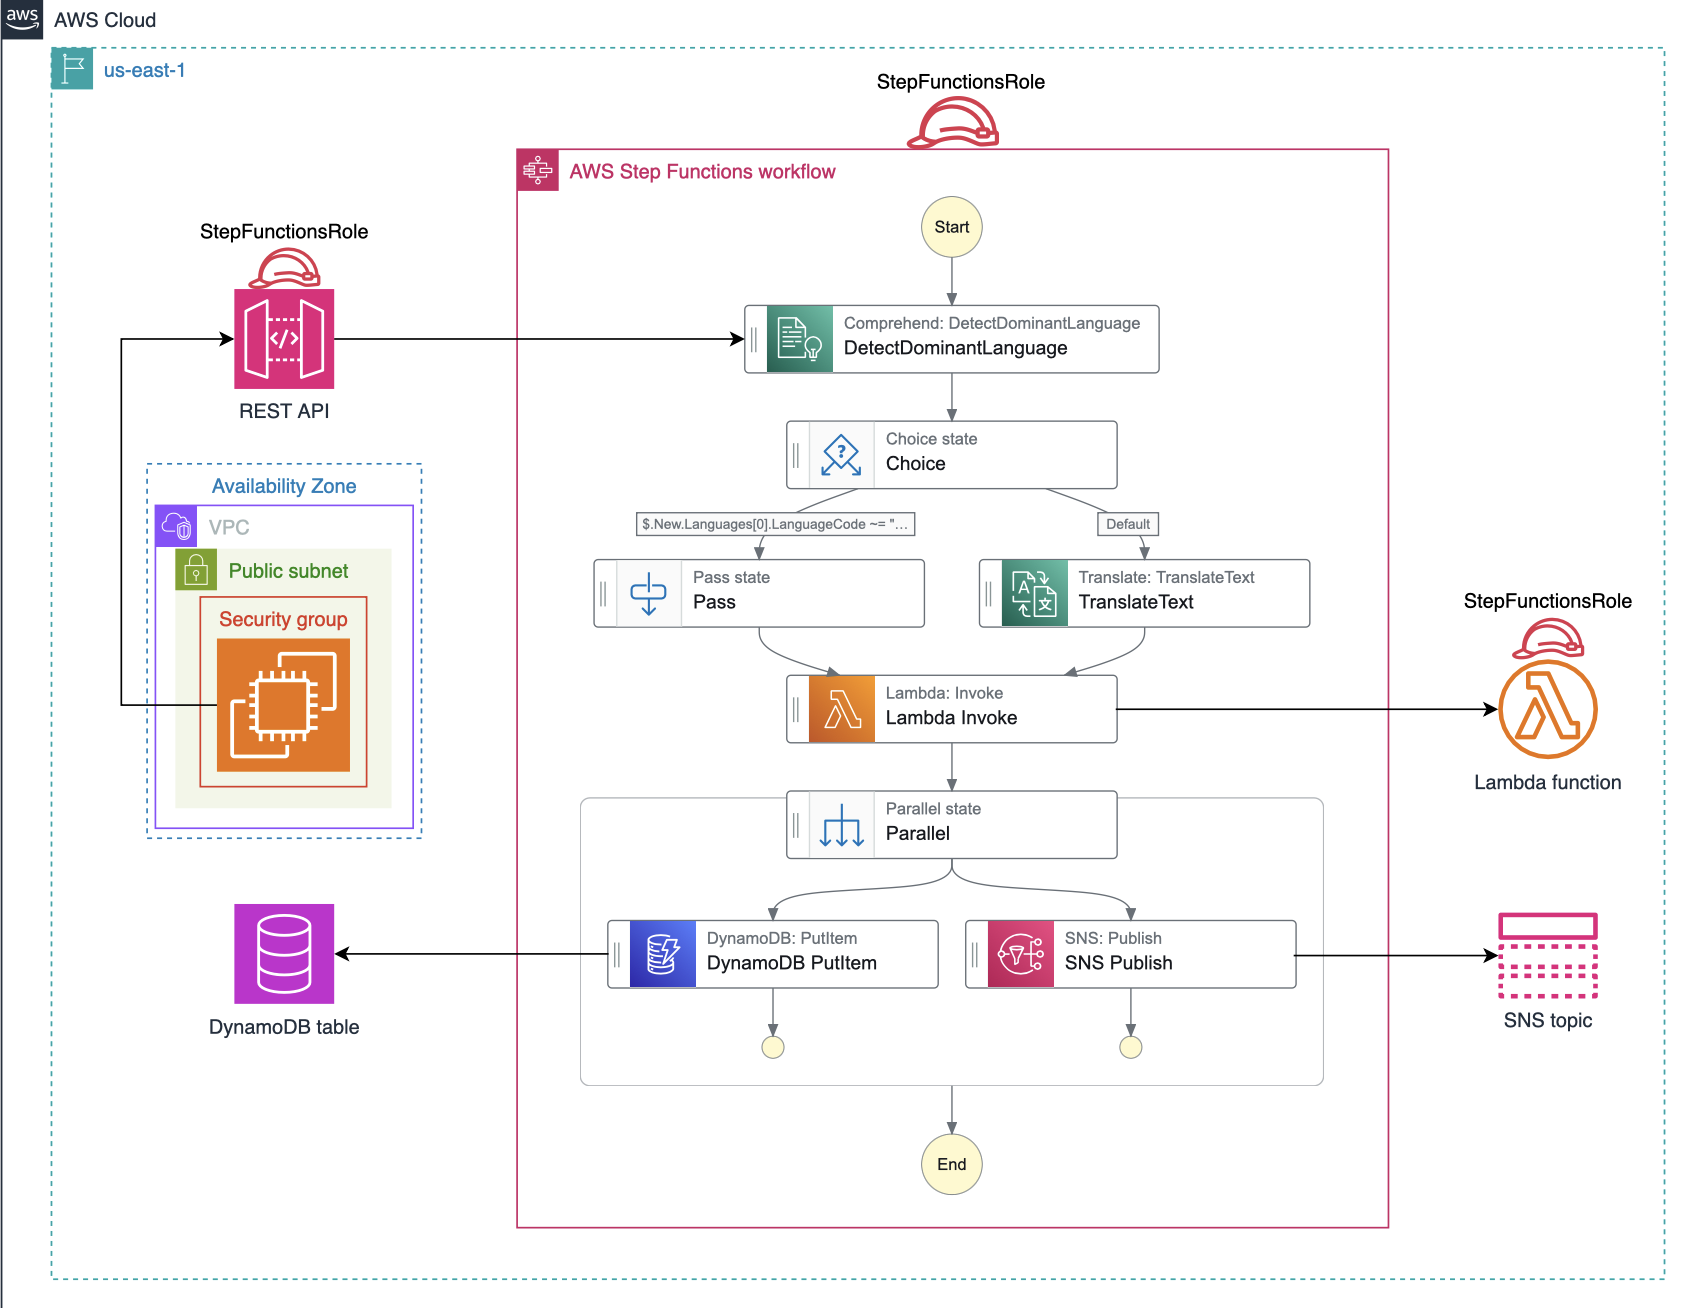

# Hosting app on EC2

The app is hosted on EC2:
```bash
# Command to install git
sudo yum -y update && sudo yum -y install git && \

# Commands to install nodejs and npm
sudo yum install https://rpm.nodesource.com/pub_16.x/nodistro/repo/nodesource-release-nodistro-1.noarch.rpm -y &&\
sudo yum install nodejs -y --setopt=nodesource-nodejs.module_hotfixes=1 && \

# Command to clone the required github repo
git clone https://github.com/Educative-Content/fundamentals-of-aws-step-functions-cl.git&& \
cd fundamentals-of-aws-step-functions-cl && \
npm init -y && \
npm install && npm install express && npm install axios && \
nano app.js
```

We also needed to create a security group that has Custom TCP inbound rule on port 3000 (we'll serve our app on this port) and SSH access too.




## Conclusion

In this Cloud Lab, we created resources to be integrated with the state machine, including an SNS topic, Lambda function, REST API, and a DynamoDB table. Then, we set up an application where a user can submit feedback. The state machine we created would be triggered on each submission, translating the feedback to English when required. Then, the state machine performed a sentiment analysis on the feedback, stored the feedback and the detected sentiment in DynamoDB, and sent a notification to the email address we provided.

